<a href="https://colab.research.google.com/github/mehrshad-sdtn/Generative-Models/blob/master/autoencoder_sketching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
#! pip install -q kaggle

In [55]:
#from google.colab import files
#files.upload()

In [56]:
#! mkdir ~/.kaggle

In [57]:
#! cp kaggle.json ~/.kaggle/

In [58]:
#! chmod 600 ~/.kaggle/kaggle.json

In [59]:
#!kaggle datasets download -d arbazkhan971/cuhk-face-sketch-database-cufs

In [60]:
#! mkdir sketch_data

In [61]:
#! unzip cuhk-face-sketch-database-cufs.zip -d sketch_data

**Main Code**

In [62]:
%cd /content/drive/MyDrive/datasets/

/content/drive/MyDrive/datasets


In [63]:
import numpy as np
import tensorflow as tf
import keras 
from keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Dropout, Input
import matplotlib.pyplot as plt
import cv2
from os.path import join
import os
import re

In [64]:
wd = os.getcwd()

In [65]:
DIM = 256

In [66]:
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)


def load_image(filepath):
  return cv2.cvtColor(
      cv2.imread(filepath), cv2.COLOR_BGR2GRAY)
  
def imshow(image):
  plt.imshow(image, cmap='gray')


def load_dir_images(path):
  array = []
  for img in [join(path, name) for name in sorted_alphanumeric(os.listdir(path))]:
    image = load_image(img)
    image = cv2.resize(image, (DIM, DIM))
    image = image.astype('float32') / 255.0
    array.append(image)
    ###### augmented images ########
    img1 = cv2.flip(image, 1)
    array.append(img1)
    img2 = cv2.flip(image, -1)
    array.append(img2)
    img3 = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    array.append(img3)
    img4 = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    array.append(img4)
    img5 = cv2.flip(img3, 1)
    array.append(img5)
    img6 = cv2.flip(img4, 1)
    array.append(img6)
    ################################
  return array


In [67]:
image_path = join(wd, 'sketch_data','photos')
img_array = load_dir_images(image_path)

sketch_path = join(wd, 'sketch_data','sketches')
sketch_array = load_dir_images(sketch_path)

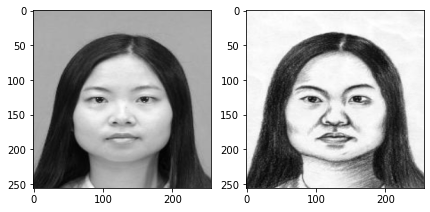

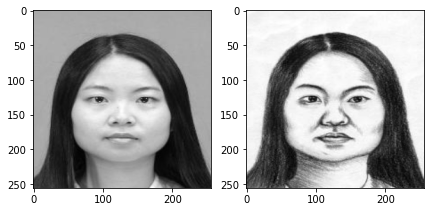

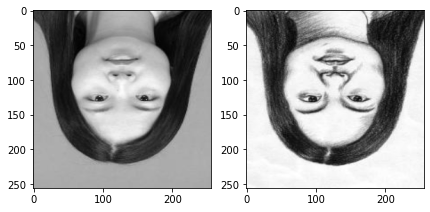

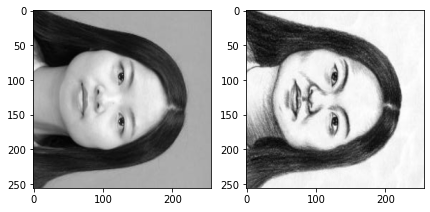

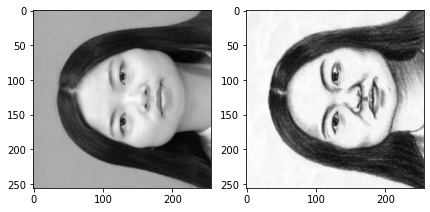

In [68]:
for i in range(0, 5):
  plt.figure(figsize=(7,7))
  plt.subplot(1, 2, 1)
  imshow(img_array[i])
  plt.subplot(1, 2, 2)
  imshow(sketch_array[i])
  plt.show()

In [69]:
print("Total number of sketch images:", len(sketch_array))
print("Total number of images:", len(img_array))

Total number of sketch images: 1316
Total number of images: 1316


In [70]:
dataset = list(zip(img_array, sketch_array))

In [71]:
import random

def train_test_split(dataset, ratio=0.9):
  length = int(len(dataset) * 0.9)
  return dataset[:length], dataset[length:]

train, test = train_test_split(dataset, ratio=0.9)

In [72]:
len(train), len(test)

(1184, 132)

In [73]:
def split_data_label(dataset):
  X, y = [], []
  for data, label in dataset:
    X.append(data)
    y.append(label)
  return np.array(X), np.array(y)


X_train, y_train = split_data_label(train)
X_test, y_test = split_data_label(test)

In [74]:
X_train.shape, y_train.shape

((1184, 256, 256), (1184, 256, 256))

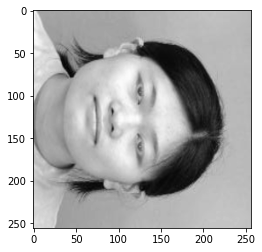

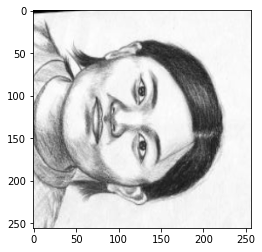

In [75]:
i = 10
imshow(X_train[i])
plt.show()
imshow(y_train[i])
plt.show()

In [105]:
encoder_input = keras.Input(shape=(DIM, DIM, 1))
x = Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', padding = 'same')(encoder_input)
x = MaxPool2D(pool_size = (2,2))(x)
x = Conv2D(filters = 32,kernel_size = (3,3),strides = (2,2), activation = 'relu', padding = 'valid')(x)
x = Conv2D(filters = 64, kernel_size = (3,3), strides = (2,2), activation = 'relu', padding = 'same')(x)
x = MaxPool2D(pool_size = (2,2))(x)
x = Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = Conv2D(filters = 256 , kernel_size = (3,3), activation = 'relu', padding = 'same')(x) 
encoder_output = Conv2D(filters = 512 , kernel_size = (3,3), activation = 'relu', padding = 'same')(x) 
encoder = tf.keras.Model(encoder_input, encoder_output)

decoder_input = Conv2D(filters = 512 ,kernel_size = (3,3), activation = 'relu', padding = 'same')(encoder_output)
x = UpSampling2D(size = (2,2))(decoder_input)
x = Conv2D(filters = 256, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = UpSampling2D(size = (2,2) )(x)
x = Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = UpSampling2D(size = (2,2) )(x)
x = Conv2D(filters = 32 , kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
x = UpSampling2D(size = (2,2) )(x)
x = Conv2D(filters = 16  , kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
decoder_output = Conv2D(filters = 1, kernel_size = (3,3), activation = 'relu', padding = 'same')(x)
model = keras.Model(encoder_input, decoder_output)

model.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_146 (Conv2D)         (None, 256, 256, 16)      160       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_147 (Conv2D)         (None, 63, 63, 32)        4640      
                                                                 
 conv2d_148 (Conv2D)         (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                     

In [112]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005), loss = 'mean_absolute_error',
              metrics = ['accuracy'])

model.fit(X_train, y_train, validation_split=0.1, epochs = 200)

Epoch 1/200
34/34 [==============================] - 7s 175ms/step - loss: 0.0540 - accuracy: 0.0377 - val_loss: 0.0942 - val_accuracy: 0.2682
Epoch 2/200
34/34 [==============================] - 6s 169ms/step - loss: 0.0411 - accuracy: 0.0384 - val_loss: 0.0921 - val_accuracy: 0.2683
Epoch 3/200
34/34 [==============================] - 6s 170ms/step - loss: 0.0393 - accuracy: 0.0385 - val_loss: 0.0940 - val_accuracy: 0.2680
Epoch 4/200
34/34 [==============================] - 6s 170ms/step - loss: 0.0389 - accuracy: 0.0386 - val_loss: 0.0938 - val_accuracy: 0.2684
Epoch 5/200
34/34 [==============================] - 6s 170ms/step - loss: 0.0387 - accuracy: 0.0386 - val_loss: 0.0946 - val_accuracy: 0.2684
Epoch 6/200
34/34 [==============================] - 6s 171ms/step - loss: 0.0387 - accuracy: 0.0386 - val_loss: 0.0943 - val_accuracy: 0.2682
Epoch 7/200
34/34 [==============================] - 6s 171ms/step - loss: 0.0385 - accuracy: 0.0387 - val_loss: 0.0936 - val_accuracy: 0.2683

In [113]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 62ms/step - loss: 0.0872 - accuracy: 0.2584


[0.08717302978038788, 0.2584340572357178]

In [114]:
preds = model.predict(X_test)

5/5 [==============================] - 0s 68ms/step


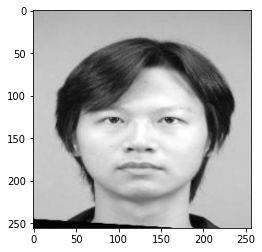

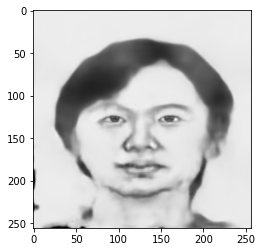

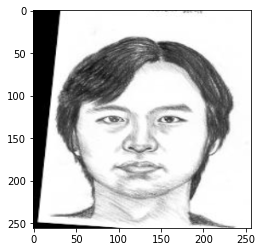

In [121]:
i = 21
imshow(X_test[i])
plt.show()
imshow(preds[i].reshape(DIM, DIM))
plt.show()
imshow(y_test[i])
plt.show()

**Out of Distribution Test**

In [ ]:
from google.colab import files
files.upload()

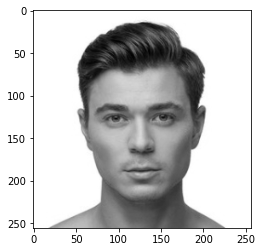

1/1 [==============================] - 0s 23ms/step


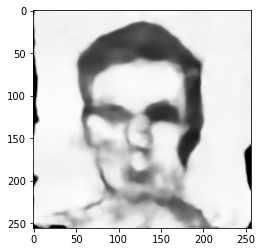

In [122]:
def prepare_test_image(path, plot=True):
  image = load_image(path)
  image = cv2.resize(image, (DIM, DIM))
  image = image.astype('float32') / 255.0
  if plot:
    imshow(image)
    plt.show()
  return np.array([image])

test_arr = prepare_test_image('face.jpg')
imshow(model.predict(test_arr).reshape(DIM, DIM))
plt.show()